In [34]:
import faiss 
import pandas as pd
import torch
from tqdm.notebook import tqdm
import glob 
import pickle
import numpy as np
from random import sample
import os
from sklearn.metrics import average_precision_score
import math
import csv
 
####################################################
## Select one of the organs: liver |colon | pancreas | lung
organ= "pancreas" 
## Select one of the ranking methods: freq | max | sum  
rankingMethod = "freq"
method = 'biomedclip_2d_search_'+rankingMethod
####################################################

## Quantification Files
quantification_dir = r"C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_quantification" 
quantification_csv = r"C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_quantification\2024.02.14.3D_MSD_Annotations.csv"

## Data  ########### Chia data nào ??
data_splits_folder = r"C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_train_test_split"
if (organ == "pancreas"):
    data_splits_folder = r"C:\Users\ADMIN\Desktop\Workspace\Code\data\msd_train_test_split\pancreas"

# 2D Embeddings 
all_embs_folder = r"C:\Users\ADMIN\Desktop\Workspace\Code\data\embeddings"
test_set_csv =  data_splits_folder + "\\" + organ + "\\" + organ + "_full_test_split.csv"

## Output files 
results_dir = "C:/Users/ADMIN/Desktop/Workspace/Code/BiomedCLIP/MSD-Final/results/results_" + organ
results_eval_metrics = results_dir + "/" + organ + "eval_metrics.csv"

## Index files
ids_organ_path = r"C:\Users\ADMIN\Desktop\Workspace\Code\BiomedCLIP\MSD-Final\2d-index\pancreas-train-2d-index\faiss_ids_embd_train.tsv"
index_organ_path = r"C:\Users\ADMIN\Desktop\Workspace\Code\BiomedCLIP\MSD-Final\2d-index\pancreas-train-2d-index\faiss_index_embd_train.index"

In [35]:
class FAISSRetrievalEngine:
    def __init__(self, ids_path, index_path):
        self.ids_path = ids_path
        
        # Load the CSV file without headers and set a default column name
        self.ids = pd.read_csv(self.ids_path, sep="\t", header=None, names=["ids_str"])
        
        # Create a dictionary mapping integers to the string IDs
        self.ids = {i: row["ids_str"] for i, row in self.ids.iterrows()}

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.index_path = index_path
        self.index = faiss.read_index(self.index_path)
        # if self.device == "cuda":
        #     res = faiss.StandardGpuResources()
        #     self.index = faiss.index_cpu_to_gpu(res, 0, self.index)
    
    def _split_array_into_batches(self, arr, batch_size):
        num_rows = arr.shape[0]
        num_batches = (num_rows + batch_size - 1) // batch_size  
        
        # Create a list of batches
        batches = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_rows)
            batch = arr[start_idx:end_idx, :]
            batches.append(batch)

        return batches

    def get_str_ids_from_I(self, I):
        mapping_fn = lambda x: self.ids.get(x, None)  # Use .get() to handle missing keys
        return np.vectorize(mapping_fn)(I)

    def retrieve_images(self, xq, k=5):
        batches = self._split_array_into_batches(xq, 16)
        output_D, output_I = [], []
        for batch in tqdm(batches, total=len(batches)):
            D, I = self.index.search(batch, k)
            I = self.get_str_ids_from_I(I)
            output_D.append(D)
            output_I.append(I)
        output_D = np.concatenate(output_D, axis=0)
        output_I = np.concatenate(output_I, axis=0)
        return output_D, output_I

# Initialize the retrieval engine
index = FAISSRetrievalEngine(
    ids_path=ids_organ_path,
    index_path=index_organ_path
)

**Running the Image Search for all test queries  
**

In [36]:
from collections import Counter    
  
def sort_by_frequency(lst):  
    freq_dict = Counter(lst)   
    return sorted(lst, key=lambda x: (-freq_dict[x], x))  

def sort_by_sum_scores(results):  
    sorted_ids = sorted(results.keys(), key=lambda x: -np.array(results[x]).sum())
    return sorted_ids 

def sort_by_max_scores(results): 
    sorted_ids = sorted(results.keys(), key=lambda x: -np.array(results[x]).max())
    return sorted_ids 
    
def get_3D_results_w_freq(slice_id_arr):
    """Baseline to get 3D img results from 2D slice results.
    Uses 2D slice count of each 3D image in the result list.

    input:
     [
        [slice_1_1, slice 1_2, ..], #results for query slice 1
        [slice_2_1, slice 2_2, ..], #results for query slice 2
        ...
     ]

     output:
     [ img_id_1, img_id_2, .., img_id_n] # initial 3D images ranked by slice count

    """
    results = []

    for i, slice_ids in enumerate(slice_id_arr):
        for slice_id in slice_ids:
            slice_str = str(slice_id)
            img_id = slice_str[:slice_str.rindex('_')]
            results.append(img_id)


    results = sort_by_frequency(results)

    result_set = set()
    final_results = []

    for r in results:
        if r not in result_set:
            final_results.append(r)
            result_set.add(r)

    return final_results

def get_3D_results_w_scores(slice_id_arr, slice_score_arr):
    results = {}
    for i, slice_ids in enumerate(slice_id_arr):
        for j, slice_id in enumerate(slice_ids):
            slice_str = str(slice_id)
            img_id = slice_str[:slice_str.rindex('_')]
            if img_id not in results:
                results[img_id] = []
            
            results[img_id].append(slice_score_arr[i][j])

    if rankingMethod == "max":  
        results = sort_by_max_scores(results)
    else: 
        if rankingMethod == "sum":  
            results = sort_by_sum_scores(results)

    result_set = set()
    final_results = []

    for r in results:
        if r not in result_set:
            final_results.append(r)
            result_set.add(r)

    return final_results

In [37]:
## Slice-based Search
search_results = {'query_img': [], 'results': []}
## Embeddings of the test set 
test_csv = pd.read_csv(test_set_csv)

for img in test_csv['testing']: 
    query_img_id = img[:img.index('.')]
    test_volume_emb = os.path.join(all_embs_folder, query_img_id + '.pkl')

    search_results['query_img'].append(query_img_id)
    with open(test_volume_emb, "rb") as f:
        embd = pickle.load(f)
    
    ## retrieving 20 slices for eval
    results = {}
    
    D, I = index.retrieve_images(embd,20)
    if rankingMethod == "freq":  
        results = get_3D_results_w_freq(I)
    else: 
        if rankingMethod in ("sum", "max"):
            results = get_3D_results_w_scores(I, D)

    search_results['results'].append(' '.join(results))

df = pd.DataFrame(search_results)

df.to_csv(results_dir + '/' + method + '_results.csv', index=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [38]:
aggregated_df = pd.read_csv(quantification_csv) 
aggregated_df['name'] = aggregated_df['name'].replace('.nii.gz', '')
for i in range(len(aggregated_df['name'])):
    filename = aggregated_df['name'][i]
    aggregated_df['name'][i] = filename[:filename.index('.')] 
aggregated_df.head()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10740\748815261.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  aggregated_df['name'][i] = filename[:filename.index('.')]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10740\748815261.py:5: Setti

,name,pancreas_max_tumor_size,number_tumors,pancreas_lesion_group,organ,pancreas_cancer_flag,pancreas_cancer_stage,Relevant query,auto_generated_caption,validate caption (Y/N),Correction if applicable,Relevant case for 3D Image Search,Additional Comments,cancer_stage
0,pancreas_001,5.104953,1,3,pancreas,1,NaN,NaN,"""This 3D volume depicts the pancreas with a si...",NaN,NaN,NaN,NaN,3.0
1,pancreas_004,6.452776,1,4,pancreas,1,NaN,NaN,This is an image of the pancreas with one tumo...,NaN,NaN,NaN,NaN,4.0
2,pancreas_005,3.639289,1,2,pancreas,1,NaN,NaN,This image depicts the pancreas with a single ...,NaN,NaN,NaN,NaN,2.0
3,pancreas_006,4.834758,1,3,pancreas,1,NaN,NaN,This is an image of the pancreas with one tumo...,NaN,NaN,NaN,NaN,3.0
4,pancreas_010,5.667779,1,3,pancreas,1,NaN,NaN,This is an image of the pancreas with one tumo...,NaN,NaN,NaN,NaN,3.0


In [39]:
# Initialize evaluation dictionaries
tumor_stage_eval  = {'query': []} 
tumor_flag_eval = {'query': []}

for i in range(10):
    tumor_stage_eval[f"Top {i+1}"] = []
    tumor_flag_eval[f"Top {i+1}"] = []

for query, res in zip(search_results['query_img'], search_results['results']):
    # Find metrics for the query image
    
    query_metrics = aggregated_df.loc[aggregated_df['name'] == query]

    if query_metrics.empty:
        print(f"Query image {query} not found in aggregated_df.")
        continue

    query_metrics = query_metrics.iloc[0]

    tumor_stage_eval['query'].append(query)
    tumor_flag_eval['query'].append(query)

    tumor_flag = organ + "_cancer_flag" 
    top_n = res.split(' ')

    
    for k, top_k in enumerate(top_n):
        if k > 9:
            break
        
        res_metrics = aggregated_df.loc[aggregated_df['name'] == top_k[:top_k.index('.')]].iloc[0]

        # res_metrics = aggregated_df.loc[aggregated_df['name'] == top_k]
        
        if res_metrics.empty:
            print(f"Top {k+1} result {top_k} not found in aggregated_df.")
            tumor_stage_eval[f"Top {k+1}"].append('NA')
            tumor_flag_eval[f"Top {k+1}"].append('NA')
            continue
        
        # Calculate tumor stage
        tumorStage = 0
        if (query_metrics['cancer_stage'] - res_metrics['cancer_stage'] == 0) and (query_metrics['pancreas_lesion_group'] - res_metrics['pancreas_lesion_group'] == 0):
            tumorStage = 1

        tumor_stage_eval[f"Top {k+1}"].append(tumorStage)
        tumor_flag_eval[f"Top {k+1}"].append(1 - abs(query_metrics[tumor_flag] - res_metrics[tumor_flag]))
    
    # Fill missing top N values with 'NA'
    if len(top_n) < 10:
        for k in range(len(top_n), 10):
            tumor_stage_eval[f"Top {k+1}"].append('NA')
            tumor_flag_eval[f"Top {k+1}"].append('NA')

# Convert results to DataFrames and save
tumor_stage_df = pd.DataFrame(tumor_stage_eval)
tumor_stage_df.to_csv(os.path.join(results_dir, method + '_tumor_stage_eval.csv'), index=False) 

tumor_flag_df = pd.DataFrame(tumor_flag_eval)
tumor_flag_df.to_csv(os.path.join(results_dir, method + '_tumor_flag_eval.csv'), index=False) 


In [40]:
## Tumor Flag
print("# Tumor Flag: ")

tumor_flag_df['RowMean'] = tumor_flag_df.iloc[:, 1:4].mean(axis=1)
overall_mean = tumor_flag_df['RowMean'].mean()
print("tumor_flag_p@3: ", '{:.4f}'.format(overall_mean))

tumor_flag_df['RowMean'] = tumor_flag_df.iloc[:, 1:6].mean(axis=1)
overall_mean = tumor_flag_df['RowMean'].mean()
print("tumor_flag_p@5: ", '{:.4f}'.format(overall_mean))

tumor_flag_df['RowMean'] = tumor_flag_df.iloc[:, 1:].mean(axis=1)
overall_mean = tumor_flag_df['RowMean'].mean()
print("tumor_flag_p@10: ", '{:.4f}'.format(overall_mean))

## Tumor Stage
print("# Tumor Stage: ")

tumor_stage_df['RowMean'] = tumor_stage_df.iloc[:, 1:4].mean(axis=1)
overall_mean = tumor_stage_df['RowMean'].mean()
print("tumor_stage_p@3: ", '{:.4f}'.format(overall_mean))

tumor_stage_df['RowMean'] = tumor_stage_df.iloc[:, 1:6].mean(axis=1)
overall_mean = tumor_stage_df['RowMean'].mean()
print("tumor_stage_p@5: ", '{:.4f}'.format(overall_mean))

tumor_stage_df['RowMean'] = tumor_stage_df.iloc[:, 1:].mean(axis=1)
overall_mean = tumor_stage_df['RowMean'].mean()
print("tumor_stage_p@10: ", '{:.4f}'.format(overall_mean))

# Tumor Flag: 
tumor_flag_p@3:  1.0000
tumor_flag_p@5:  1.0000
tumor_flag_p@10:  1.0000
# Tumor Stage: 
tumor_stage_p@3:  0.5714
tumor_stage_p@5:  0.5429
tumor_stage_p@10:  0.5104


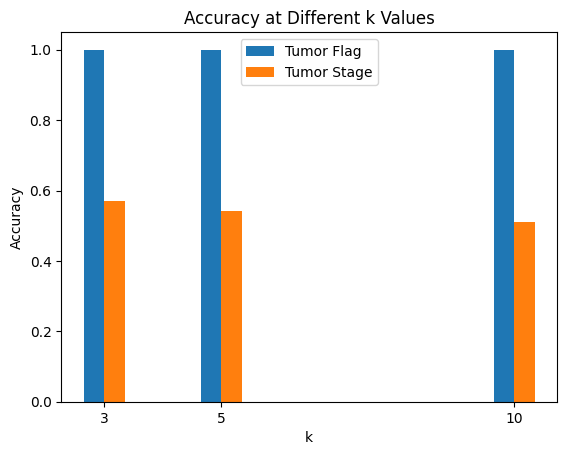

In [41]:
import matplotlib.pyplot as plt

# Accuracy values for tumor flag and tumor stage
k_values = [3, 5, 10]
tumor_flag_accuracy = [1.0000, 1.0000, 1.0000]
tumor_stage_accuracy = [0.5714, 0.5429, 0.5104]

# Create the bar plot
fig, ax = plt.subplots()
width = 0.35  # Width of the bars

# Plot tumor flag accuracy
ax.bar([x - width/2 for x in k_values], tumor_flag_accuracy, width, label='Tumor Flag')

# Plot tumor stage accuracy
ax.bar([x + width/2 for x in k_values], tumor_stage_accuracy, width, label='Tumor Stage')

# Adding labels and title
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy at Different k Values')
ax.set_xticks(k_values)
ax.legend()

# Show the plot
plt.show()


In [42]:
ref_tumor_flag = []
all_res_tumor_flag = []
ref_tumor_stage = []
all_res_tumor_stage = []

for query, res in zip(search_results['query_img'], search_results['results']):
    query_metrics = aggregated_df.loc[aggregated_df['name'] == query].iloc[0]
    tumor_flag = organ + "_cancer_flag" 
    ref_tumor_flag.append(query_metrics[tumor_flag])
    ref_tumor_stage.append(query_metrics['cancer_stage'])
    top_n = res.split(' ')
    res_tumor_flag = []
    res_tumor_stage = []
    for k, top_k in enumerate(top_n):
        if k > 9:
            break
        res_metrics = aggregated_df.loc[aggregated_df['name'] == top_k[:top_k.index('.')]].iloc[0]
        res_tumor_flag.append(res_metrics[tumor_flag])
        res_tumor_stage.append(res_metrics['cancer_stage'])
    all_res_tumor_flag.append(res_tumor_flag)
    all_res_tumor_stage.append(res_tumor_stage)

## Adaptation for Average Precision (AP) computation
## AP - Tumor Flag
for i, q in enumerate(ref_tumor_flag):
    if q == 0:
        for j, res in enumerate(all_res_tumor_flag[i]):
            if res == 0:
                all_res_tumor_flag[i][j] = 1
            else:
                all_res_tumor_flag[i][j] = 0

## AP - Tumor Stage
for i, q in enumerate(ref_tumor_stage):
    print(q)
    for j, res in enumerate(all_res_tumor_stage[i]):
        if res == q:
            all_res_tumor_stage[i][j] = 1
        else:
            all_res_tumor_stage[i][j] = 0

1.0
1.0
1.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
3.0
3.0
3.0
3.0
3.0
3.0


In [43]:
##############
## Tumor Flag
##############

ref_tumor_flag = np.array(ref_tumor_flag)
all_res_tumor_flag = np.array(all_res_tumor_flag)
ap = 0

for i, q in enumerate(ref_tumor_flag):
    try:
        flag_avg_precision =  average_precision_score(all_res_tumor_flag[i], list(range(len(all_res_tumor_flag[i])))[::-1])

        if math.isnan(flag_avg_precision):
            flag_avg_precision=0

        ap = ap + flag_avg_precision
    except:
        print(all_res_tumor_flag[i])
        
print("flag_avg_precision: ", '{:.4f}'.format(ap/len(ref_tumor_flag)))

flag_avg_precision:  1.0000


In [44]:
###############
## Tumor Stage
###############

ref_tumor_stage = np.array(ref_tumor_stage)
all_res_tumor_stage = np.array(all_res_tumor_stage)
ap = 0
 
for i, q in enumerate(ref_tumor_stage):
    try:
        stage_avg_precision =  average_precision_score(all_res_tumor_stage[i], list(range(len(all_res_tumor_flag[i])))[::-1])
        if math.isnan(stage_avg_precision):
            stage_avg_precision=0
        ap = ap + stage_avg_precision
    except:
        print(all_res_tumor_stage[i])

print("stage_avg_precision: ", '{:.4f}'.format(ap/len(ref_tumor_stage)))

stage_avg_precision:  0.7611
